In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats 
from scipy.stats import mannwhitneyu, wilcoxon, kruskal, shapiro

import ArapFunctions
from ArapFunctions import flag_alt_products, get_alt_product_count, show_substitutes, show_internal_external,\
query_table, viz_data, filter_by_asin, non_parametric_test

import warnings
warnings.filterwarnings('ignore')

### Alternate Purchase Behavior

In [ ]:
## query alternate purchase wkly table in bq
sql_query = """
SELECT
  start_date,
  asin,
  product_title,
  n1_purchased_asin,
  n1_purchased_product_title,
  n1_purchased_percent,
  n2_purchased_asin,
  n2_purchased_product_title,
  n2_purchased_percent,
  n3_purchased_asin,
  n3_purchased_product_title,
  n3_purchased_percent
FROM 
  `cp-gaa-visualization-dev.arap.alternate_purchase_wly` 
WHERE 
  country = 'USA'
"""

alt_purchase = query_table(sql_query)

#### How many unique products are in this table? 

In [ ]:
prod_catalog = alt_purchase['product_title'].unique().tolist()
print(f'There are {len(prod_catalog)} unique prodcuts')

#### Filtering for only toothpaste subcategory

In [ ]:
alt_purchase_toothpaste = alt_purchase[alt_purchase['product_title'].str.contains('Toothpaste')]

In [ ]:
print(f"There are {len(alt_purchase_toothpaste['product_title'].unique().tolist())} unique Toothpaste products")

In [ ]:
toothpaste_catalog = alt_purchase_toothpaste['product_title'].unique().tolist()

In [ ]:
# Output from flag_alt_products for n1, n2, and n3 columns
alt_purchase_1 = flag_alt_products(alt_purchase_toothpaste, prod_catalog)
alt_purchase_2 = flag_alt_products(alt_purchase_toothpaste, prod_catalog, column='n2_purchased_product_title')
alt_purchase_3 = flag_alt_products(alt_purchase_toothpaste, prod_catalog, column='n3_purchased_product_title')

#### Each the time a Colgate product in the toothpaste category is viewed, shoppers switched to  an alternate (External) product approximatley 50% of time (April 2018 - February 2020)

- #### The questions that immediately emerge are: 
    - #### What did they switch to? 
    - #### Did they switch to substitutes?
    - #### If so, by how much?
    

See the figure below

In [ ]:
show_internal_external(alt_purchase_1.n1_internal)

#### The switch into substitutes occurs only 5% of the time.

- #### The larger share of the switch is into colagte products and other non-related products
- #### The question that emgerges is:
    - #### What is the share of product 

In [ ]:
show_substitutes(alt_purchase_1.n1_substitute)

In [ ]:
alt_purchase_mask_1 = alt_purchase_2.loc[:, ['product_title', 'n2_purchased_product_title', 'n2_internal', 'n2_substitute']]
alt_purchase_mask_2 = alt_purchase_3.loc[:, ['product_title', 'n3_purchased_product_title', 'n3_internal', 'n3_substitute']]

alt_purchase_merge_2 = pd.merge(alt_purchase_1, alt_purchase_mask_1, on='product_title', right_index=True, left_index=True)
alt_purchase_merge_3 = pd.merge(alt_purchase_merge_2, alt_purchase_mask_2, on='product_title', right_index=True, left_index=True)


In [ ]:
alt_purchase_merge_3.head(3)

<img src="./pipe.jpg" alt="drawing" width="600"/>


  ### BigQuery => Notebook => BigQuery => Report on Data Studio 

[ARAP Alternate Purchase Behavior Dashboard](https://datastudio.google.com/u/0/reporting/1qhCsNx2dfy9EtKtiUYHBzwgInbeP1WIx/page/4rAHB)

### Data Transformations

In [ ]:
## query sales diag wkly table in bq
sql_query = """
SELECT
  start_date,
  asin,
  ordered_revenue, 
  ordered_units, 
  ordered_revenue_perc_of_total,
  average_sales_price,
  average_sales_price_prior_period,
  lbb_price,
  category,
  subcategory,
  product_title,
  company
    
FROM 
  `cp-gaa-visualization-dev.arap.sales_diagnostic_detail_wly`
 
WHERE 
  asin IN ('B07961C65H', 'B01BNEWDFQ', 'B079FV6PRH') 
"""

sales_wly = query_table(sql_query)

In [ ]:
sales_wly['ordered_revenue'] = sales_wly['ordered_revenue'].astype(float)
sales_wly['average_sales_price'] = sales_wly['average_sales_price'].astype(float)
sales_wly['lbb_price'] = sales_wly['lbb_price'].astype(float)

sales = filter_by_asin(sales_wly)

sales_flt = sales.loc[:, ['lbb_price', 'ordered_revenue', 'average_sales_price']]
sales_flt = sales_flt[(sales_flt['lbb_price'] != 0) & (sales_flt['ordered_revenue'] != 0)]

In [ ]:
viz_data(sales_flt)

In [ ]:
viz_data(sales_flt, line=False, scatter_reg=True)

### Hypothesis Testing

In [81]:
## query demographics age wkly table in bq
sql_query = """
SELECT 
  start_date,
  age,
  ordered_revenue,
  ordered_units,
  unique_customers
FROM 
  `cp-gaa-visualization-dev.arap.demographics_age_asin_detail_wly` 
  
-- WHERE company = 'COLGATE'

"""
df_dem_age = query_table(sql_query)

Downloading: 100%|██████████| 3950/3950 [00:00<00:00, 5609.28rows/s]


In [ ]:
age_18_24 = df_dem_age.loc[df_dem_age['age'] == '18-24', 'ordered_revenue']
age_25_34 = df_dem_age.loc[df_dem_age['age'] == '25-34', 'ordered_revenue']
age_35_44 = df_dem_age.loc[df_dem_age['age'] == '35-44', 'ordered_revenue']

In [ ]:
age_18_24.hist();

In [ ]:
age_25_34.hist();

In [ ]:
age_35_44.hist();

In [ ]:
stat, p = shapiro(age_18_24)
print(f'Statistics={stat}, p={p}')

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

In [ ]:
non_parametric_test(age_18_24, age_25_34, age_35_44, anova_test=False, h_test=True)

In [ ]:
def query_table(sql_query):
    """
    
    """
    
    return pandas_gbq.read_gbq(sql_query, project_id=project_id)

In [2]:
## query alternate purchase wkly table in bq
sql_query = """
SELECT
  start_date,
  asin,
  product_title,
  n1_purchased_asin,
  n1_purchased_product_title,
  n1_purchased_percent,
  n2_purchased_asin,
  n2_purchased_product_title,
  n2_purchased_percent,
  n3_purchased_asin,
  n3_purchased_product_title,
  n3_purchased_percent
FROM 
  `cp-gaa-visualization-dev.arap.alternate_purchase_wly` 
WHERE 
  country = 'USA' and company LIKE '%HILLS'
"""

hills_alt_purchase_qry = query_table(sql_query)

Downloading: 100%|██████████| 29020/29020 [00:04<00:00, 5819.77rows/s]


In [3]:
prod_catalog = hills_alt_purchase_qry['product_title'].unique().tolist()
print(f'There are {len(prod_catalog)} unique prodcuts')

There are 706 unique prodcuts


In [4]:
hills_alt_purchase = hills_alt_purchase_qry[hills_alt_purchase_qry['product_title'].str.contains("Hill's")]

In [5]:
hills_catalog = hills_alt_purchase['product_title'].unique().tolist()

In [ ]:
len(hills_catalog)

In [ ]:
alt_catalog = hills_alt_purchase['n1_purchased_product_title'].unique().tolist()

In [ ]:
len(alt_catalog)

In [ ]:
list1 = [10, 15, 20, 25, 30, 35, 40]
list2 = [25, 40, 35] 

In [ ]:
set(list1) - set(list2)

In [ ]:
def Diff(li1, li2): 
    return (set(li1) - set(li2)) 

In [ ]:
len(Diff(hills_catalog, alt_catalog))

In [ ]:
len(hills_catalog)

In [ ]:
## Add to the prod_catalog list
for i in alt_catalog:
    if ("Hill's" in i) and (i not in hills_catalog):
        hills_catalog.append(i)
print(f'There are now {len(hills_catalog)} unique prodcuts')

In [ ]:
pet_keywords = ['Dog', 'Cat', 'Wet', 'Dry', 'Kitten', 'Treats']

In [ ]:
#hills_catalog

In [ ]:
"(Dog Food)|(Cat Food)|(Dog Treats)|(Cat Treats)|(Wet Dog Food)|(Wet Cat Food)|(Dry Dog Food)|(Dry Cat Food)|(Dry Dog Treats)|(Dry Cat Treats)|(Wet Dog Treats)|(Wet Cat Treats)"

In [ ]:
not_hills_catalog = []
for i in hills_alt_purchase['n1_purchased_product_title'].tolist():
    if (i.lower() not in hills_catalog) and ("hill's" not in i.lower()):
        not_hills_catalog.append(i)

In [7]:
import re

In [5]:
for i in test_list2:
    try:
        if "Hill's" in i[0]:
            print(i[0])
        else:
            pass
    except IndexError:
        continue
    
    

In [55]:
for i in test_list2[140:160]:
    if i == []:
        print(i, 'no')
    elif "Hill's" in i[0]:
        print(i, 'No')
    else:
        print(i, 'yes')

[] no
[] no
[('', '', '', '', '', '', '', '', '', '', '', '', '', 'Chews')] yes
[('', '', '', '', '', '', '', '', '', '', '', '', '', 'Chews'), ('', '', '', 'Dog Treats', '', '', '', '', '', '', '', '', '', '')] yes
[] no
[] no
[("Hill's", '', '', '', '', '', '', '', '', '', '', '', '', ''), ('', '', '', '', '', '', '', 'Dry Dog Food', '', '', '', '', '', '')] No
[("Hill's", '', '', '', '', '', '', '', '', '', '', '', '', ''), ('', '', '', '', '', '', '', 'Dry Dog Food', '', '', '', '', '', '')] No
[("Hill's", '', '', '', '', '', '', '', '', '', '', '', '', ''), ('', '', '', 'Dog Treats', '', '', '', '', '', '', '', '', '', '')] No
[("Hill's", '', '', '', '', '', '', '', '', '', '', '', '', ''), ('', '', '', '', '', '', '', 'Dry Dog Food', '', '', '', '', '', '')] No
[("Hill's", '', '', '', '', '', '', '', '', '', '', '', '', ''), ('', '', '', '', '', '', 'Wet Cat Food', '', '', '', '', '', '', '')] No
[("Hill's", '', '', '', '', '', '', '', '', '', '', '', '', ''), ('', '', '', '', ''

In [40]:
for i in test_list2[140:160]:
    if i == []:
        print('No')
    elif "Hill's" not in i[0] or "Hill's" not in i[1]:
        print('Yes')

No
No
Yes
Yes
No
No
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes


In [72]:
test_list2 = []
title = hills_alt_purchase['product_title'].tolist()
title_lower = [i.lower() for i in title]
n1_title = hills_alt_purchase['n1_purchased_product_title'].tolist()
n1_title_lower = [i.lower() for i in n1_title]
for i in n1_title_lower:
    x = re.findall("(hill's)|(dog food)|(cat food)|(dog treats)|(cat treats)|(wet dog food)|(wet cat food)|(dry dog food)|(dry cat food)|(dry dog treats)|(dry cat treats)|(wet dog treats)|(wet cat treats)|(chews)", i)
    test_list2.append(x)

print(len(test_list2))
print(len(hills_alt_purchase['n1_purchased_product_title'].tolist()))

subs = []
not_subs = []


for i in test_list2:
    if i == []:
        #print(i, 'no')
        subs.append('no')
    elif "hill's".lower() in i[0]:
        #print(i, 'No')
        subs.append('no')
    else:
        #print(i, 'yes')
        subs.append('yes')
        
df = pd.DataFrame({'col1': title,
              'col2': n1_title,
             'col3': test_list2,
            'sub': subs})

21927
21927


In [73]:
df[df['sub'] == 'yes']

,col1,col2,col3,sub
115,Grain Free Dry Cat Food by Hill's Science Diet...,Grain Free Dry Cat Food by Hill's Science Diet...,"[(, , , , , , , , dry cat food, , , , , ), (hi...",yes
134,Hill's Science Diet Dry Cat Food Adult Indoor ...,Weruva Cats in the Kitchen Pantry Party Pouch ...,"[(, , cat food, , , , , , , , , , , )]",yes
142,Hill's Science Diet Dry Dog Food Adult 6+ Larg...,SmartBones Mini Chicken Chews (24 Pack),"[(, , , , , , , , , , , , , chews)]",yes
143,Hill's Science Diet Dry Dog Food Adult Light f...,GREENIES Regular Natural Dog Dental Care Chews...,"[(, , , , , , , , , , , , , chews), (, , , dog...",yes
209,Hill's Pet Nutrition Metabolic Weight Manageme...,VetriScience Laboratories Composure Calming Su...,"[(, , , , , , , , , , , , , chews), (, , , , ,...",yes
...,...,...,...,...
10740,Hill's Science Diet Dry Dog Food Adult Large B...,Blue Buffalo Wilderness Trail Treats Wild Bits...,"[(, , , dog treats, , , , , , , , , , )]",yes
10747,Hill's Pet Nutrition K/d Kidney Care Vegetable...,VetriScience Laboratories Renal Essentials Kid...,"[(, , , , , , , , , , , , , chews)]",yes
10820,Hill's Prescription Diet z/d Canine Ultra Alle...,Wellness Simple Natural Grain Free Dry Limited...,"[(, dog food, , , , , , , , , , , , )]",yes
10848,Hill's Science Diet Dry Dog Food Adult Light C...,Nature's Recipe Chicken Rice & Barley Recipe W...,"[(, , , , , wet dog food, , , , , , , , )]",yes


In [ ]:
limit = 1000000000
jupyter --NotebookApp.iopub_data_rate_limit=1.0e10

In [ ]:
print(len(subs))
print(test_list2)
print(title)

In [ ]:
y = []
for i in substitute_list:
    if i == 'yes':
        y.append(i)
print(len(y))
len(substitute_list)

In [ ]:
len(hills_alt_purchase['n1_purchased_product_title'].tolist())

In [74]:
def flag_alt_products(data, prod_catalog, column='n1_purchased_product_title'):
    hills_catalog = data['product_title'].unique().tolist()
    asin_list = data['asin'].tolist()
    prod_list = data['product_title'].tolist()
    date_list = data['start_date'].tolist()
    alt_purchase_list = data[column].tolist()
    alt_catalog = data[column].unique().tolist()
    prefix = column.split('_')[0]
    hills_keywords = ['Dog', 'Cat', 'Wet', 'Dry', 'Kitten', 'Treats']
    
    internal_list = []
    external_list = []
    substitute_list = []
    sub_external_list = []
    Yes = 'yes'
    No = 'no'
           
    
    
    alt_purchase_list_lower = [i.lower() for i in alt_purchase_list]
    
    for i in alt_purchase_list_lower:
        x = re.findall("(hill's)|(dog food)|(cat food)|(dog treats)|(cat treats)|(wet dog food)|(wet cat food)|(dry dog food)|(dry cat food)|(dry dog treats)|(dry cat treats)|(wet dog treats)|(wet cat treats)|(chews)", i)
        sub_external_list.append(x)

    for i in alt_purchase_list:
        # Competitors:
            # Case 1
        if i in prod_catalog:
            a1 = Yes
            internal_list.append(a1)
            # Case 2
        else:
            a2 = No
            internal_list.append(a2)

        # Substitutes:
            # Case 2       
    for i in sub_external_list:
        if i == []:
            b1 = No
            substitute_list.append(b1)
        elif "hill's".lower() in i[0]:
            b2 = No
            substitute_list.append(b2)
        else:
            b3 = Yes
            substitute_list.append(Yes)

    return pd.DataFrame({'start_date': date_list, 
                  'asin': asin_list,
                  'product_title': prod_list, 
                  f'{column}': alt_purchase_list,
                  f'{prefix}_internal': internal_list, 
                  f'{prefix}_substitute': substitute_list}) 

In [76]:
hills_alt_product_1 = flag_alt_products(hills_alt_purchase, prod_catalog)

yes    94.978793
no      5.021207
Name: n1_internal, dtype: float64


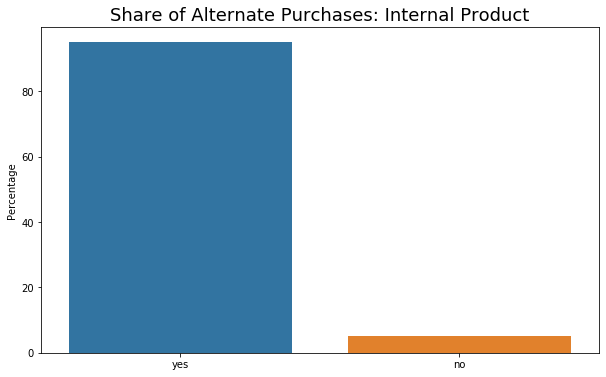

In [78]:
show_internal_external(hills_alt_product_1.n1_internal)

no     98.83705
yes     1.16295
Name: n1_substitute, dtype: float64


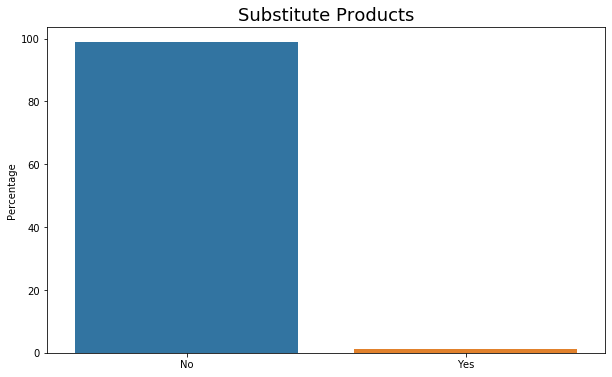

In [79]:
show_substitutes(hills_alt_product_1.n1_substitute)